In [37]:
import pandas as pd
import researchpy as py
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

#####KEEP CATEGORY OF INTEREST IN POS 0

cat = ['IncomeDisposable','CommunitySupport']

def readcsv(name, cat_Type, *categories):
    df = pd.read_csv(name)


    df = df.replace(r'^\s*$', np.nan, regex=True)

    for category in categories:
        df[category] = df[category].astype(cat_Type)
        
    return df

df =readcsv('2020Data.csv',float,cat)




def percentiles(dfz,percentile,label,cat_v ,percentile_cat):
    
    percentile_label = []
    cat_Var = []

    for i in percentile:#can add bins here, for now not necessary but will allow cuts into more percentiles
         percentile_label.append(np.nanpercentile(dfz[percentile_cat],i))
            
    dfz[cat_v] = pd.cut(dfz[percentile_cat],
                             bins = [percentile_label[0],percentile_label[1],percentile_label[2],
                                     percentile_label[3],float('Inf')],
                             labels =label, precision = 4 )
#         print(category[z])
    cat_Var.append(dfz[percentile_cat].dropna())
#         print(z)

    print(percentile_label)
    return dfz,cat_Var

df,cat_Var = percentiles(df,[0,25,50,75],[0,1,2,3],'wlblP',cat[1])

# print(df['wlblP'])
# print(df[cat[0]])

new_df = df[[cat[0],cat[1],'wlblP']]
new_df = new_df.dropna()
new_df = new_df.drop([0,7,13,31,39])
wlbh13 =  new_df[cat[0]].dropna()
wlbl13 = new_df[cat[1]].dropna()

ANOVA =stats.f_oneway(new_df[cat[0]][new_df['wlblP']==0],
              new_df[cat[0]][new_df['wlblP']==1],
              new_df[cat[0]][new_df['wlblP']==2],
              new_df[cat[0]][new_df['wlblP']==3],)



# print(df['wlblP'].dropna())
# print(wlbh13)
print(ANOVA)
print(new_df)
##p val less than alpha, significant result, wlbl and wlbh have significant difference

[78.0, 88.0, 91.0, 93.0]
F_onewayResult(statistic=4.726901042835324, pvalue=0.01254795595901964)
    IncomeDisposable  CommunitySupport wlblP
1            33541.0              92.0     2
2            30364.0              91.0     1
4            30854.0              93.0     2
8            29606.0              95.0     3
9            19697.0              92.0     2
10           29943.0              95.0     3
11           31304.0              90.0     1
12           34294.0              90.0     1
16           25310.0              95.0     3
18           26588.0              92.0     2
19           29798.0              89.0     1
21           16275.0              86.0     0
22           21660.0              88.0     0
23           39264.0              93.0     2
25           29333.0              91.0     1
27           35725.0              94.0     3
28           19814.0              86.0     0
29           21203.0              88.0     0
32           20820.0              92.0     2
34 

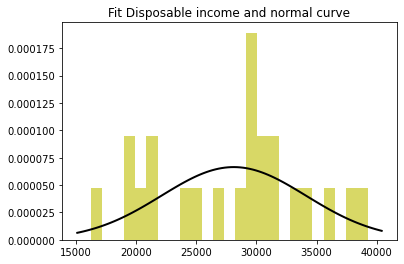

In [45]:
mu,std = stats.norm.fit(wlbh13)

plt.hist(wlbh13, bins=25, density = True, alpha=0.6, color = 'y')
xmin,xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = stats.norm.pdf(x,mu,std)
plt.plot(x,p,'k',linewidth = 2)
title = "Fit Disposable income and normal curve"
plt.title(title)
plt.show()

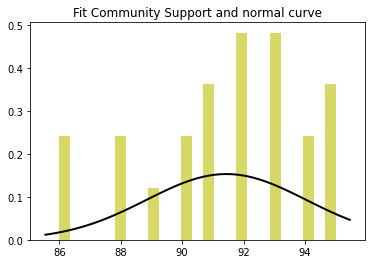

In [44]:
mu,std = stats.norm.fit(wlbl13)

plt.hist(wlbl13, bins=25, density = True, alpha=0.6, color = 'y')
xmin,xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = stats.norm.pdf(x,mu,std)
plt.plot(x,p,'k',linewidth = 2)
title = "Fit Community Support and normal curve"
plt.title(title)
plt.show()

In [43]:
stats.levene(new_df[cat[0]][new_df['wlblP']==0].dropna(),
              new_df[cat[0]][new_df['wlblP']==1].dropna(),
              new_df[cat[0]][new_df['wlblP']==2].dropna(),
              new_df[cat[0]][new_df['wlblP']==3].dropna(),center = 'mean')

##from levene test samples have diff variances, also obv by looking at norm plot and box plot


LeveneResult(statistic=6.128372671261436, pvalue=0.004278872930556317)

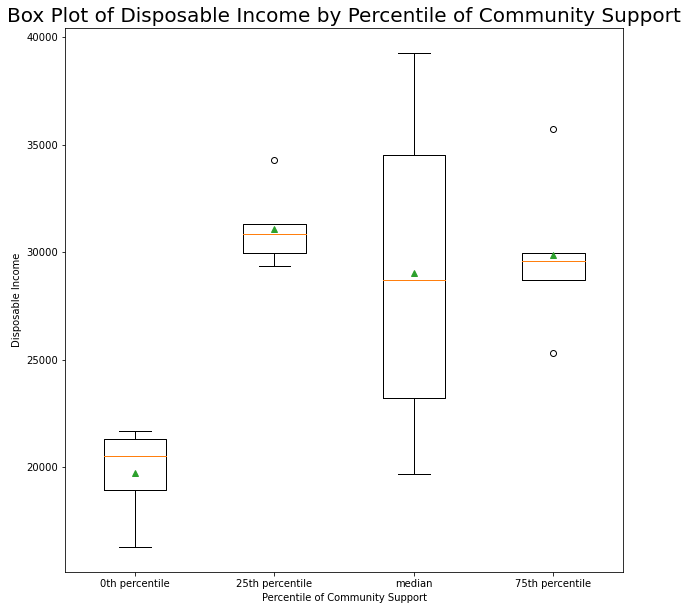

In [42]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Disposable Income by Percentile of Community Support", fontsize= 20)
ax.set

data = [new_df[cat[0]][new_df['wlblP']==0].dropna(),
              new_df[cat[0]][new_df['wlblP']==1].dropna(),
              new_df[cat[0]][new_df['wlblP']==2].dropna(),
              new_df[cat[0]][new_df['wlblP']==3].dropna()]

ax.boxplot(data,
           labels= ['0th percentile', '25th percentile', 'median','75th percentile'],
           showmeans= True)

plt.xlabel("Percentile of Community Support")
plt.ylabel("Disposable Income")

plt.show()

In [41]:
from collections import namedtuple
def welch_anova_np(*args, var_equal=False):
    # https://svn.r-project.org/R/trunk/src/library/stats/R/oneway.test.R
    # translated from R Welch ANOVA (not assuming equal variance)

    F_onewayResult = namedtuple('F_onewayResult', ('statistic', 'pvalue'))

    args = [np.asarray(arg, dtype=float) for arg in args]
    k = len(args)
    ni =np.array([len(arg) for arg in args])
    mi =np.array([np.mean(arg) for arg in args])
    vi =np.array([np.var(arg,ddof=1) for arg in args])
    wi = ni/vi

    tmp =sum((1-wi/sum(wi))**2 / (ni-1))
    tmp /= (k**2 -1)

    dfbn = k - 1
    dfwn = 1 / (3 * tmp)

    m = sum(mi*wi) / sum(wi)
    f = sum(wi * (mi - m)**2) /((dfbn) * (1 + 2 * (dfbn - 1) * tmp))
    prob = stats.f.sf(dfbn, dfwn, f)
    return F_onewayResult(f, prob)

welch_anova_np(new_df[cat[0]][new_df['wlblP']==0],
              new_df[cat[0]][new_df['wlblP']==1],
              new_df[cat[0]][new_df['wlblP']==2],
              new_df[cat[0]][new_df['wlblP']==3])

F_onewayResult(statistic=18.827909616999925, pvalue=0.02133851516691594)

In [52]:
from scikit_posthocs import posthoc_tamhane

g1 = new_df[cat[0]][new_df['wlblP']==0]
g2 = new_df[cat[0]][new_df['wlblP']==1]
g3 = new_df[cat[0]][new_df['wlblP']==2]
g4 = new_df[cat[0]][new_df['wlblP']==3]
data = [g1,g2,g3,g4]

posthoc_tamhane(data)

,1,2,3,4
1,1.000000,0.001810,0.039971,0.007792
2,0.001810,1.000000,0.924530,0.954139
3,0.039971,0.924530,1.000000,0.998223
4,0.007792,0.954139,0.998223,1.000000


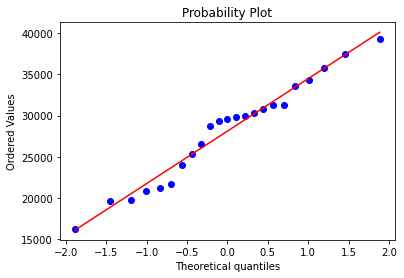

ShapiroResult(statistic=0.9656952023506165, pvalue=0.5872083902359009)

In [39]:
fig = plt.figure()
ax=fig.add_subplot(111)
res = stats.probplot(new_df[cat[0]],plot=ax)
plt.show()
stats.shapiro(new_df[cat[0]])

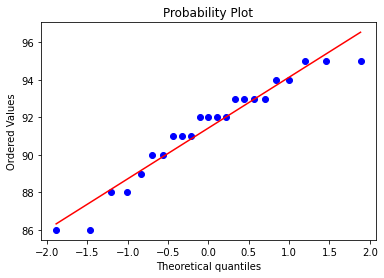

ShapiroResult(statistic=0.933332622051239, pvalue=0.12908585369586945)

In [38]:
fig = plt.figure()
ax=fig.add_subplot(111)
res = stats.probplot(new_df[cat[1]],plot=ax)
plt.show()
stats.shapiro(new_df[cat[1]])